# Four-Bar Linkage Position Analysis (Newton's Method for a Nonlinear System)

This notebook computes the four-bar configuration for a sequence of input angles $\theta_2$ by solving the nonlinear loop-closure equations for the unknown angles $\theta_3$ and $\theta_4$.

We then animate the mechanism motion.

**Key idea:** For each $\theta_2$, solve the 2×2 nonlinear system
\begin{equation}
\begin{aligned}
f_1(\theta_3,\theta_4) &= r_2\cos\theta_2 + r_3\cos\theta_3 - r_1 - r_4\cos\theta_4 = 0,\\
f_2(\theta_3,\theta_4) &= r_2\sin\theta_2 + r_3\sin\theta_3 - r_4\sin\theta_4 = 0.
\end{aligned}
\end{equation}
using Newton’s method:
\begin{equation}
J\,\Delta x = -F,\qquad x \leftarrow x + \Delta x,
\end{equation}
where $x=[\theta_3,\theta_4]^T$.


In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Pretty plots in notebooks
plt.rcParams['figure.dpi'] = 120


## 1) Define the nonlinear system and Jacobian (SymPy → NumPy)

In [2]:
# Unknowns
th3, th4 = sp.symbols('th3 th4', real=True)

# Parameters
r1, r2, r3, r4, th2 = sp.symbols('r1 r2 r3 r4 th2', positive=True, real=True)

# Loop-closure equations
f1 = r2*sp.cos(th2) + r3*sp.cos(th3) - r1 - r4*sp.cos(th4)
f2 = r2*sp.sin(th2) + r3*sp.sin(th3) - r4*sp.sin(th4)

F = sp.Matrix([f1, f2])
J = F.jacobian([th3, th4])

F_simpl = sp.simplify(F)
J_simpl = sp.simplify(J)

F_simpl, J_simpl


(Matrix([
 [-r1 + r2*cos(th2) + r3*cos(th3) - r4*cos(th4)],
 [      r2*sin(th2) + r3*sin(th3) - r4*sin(th4)]]),
 Matrix([
 [-r3*sin(th3),  r4*sin(th4)],
 [ r3*cos(th3), -r4*cos(th4)]]))

In [3]:
# Convert to numerical callables
F_num = sp.lambdify((th3, th4, r1, r2, r3, r4, th2), F_simpl, 'numpy')
J_num = sp.lambdify((th3, th4, r1, r2, r3, r4, th2), J_simpl, 'numpy')


## 2) Newton solver for a 2×2 system

In [4]:
def newton_2x2(th3_0, th4_0, r1v, r2v, r3v, r4v, th2v,
               tol=1e-12, max_iter=30):
    """Newton solve F(th3,th4)=0 for a given input th2v.

    Returns: th3, th4, converged(bool), iters, residual_norm
    """
    th3k = float(th3_0)
    th4k = float(th4_0)

    for k in range(max_iter):
        Fk = np.array(F_num(th3k, th4k, r1v, r2v, r3v, r4v, th2v), dtype=float).reshape(2,)
        rk = np.linalg.norm(Fk, ord=2)

        if rk < tol:
            return th3k, th4k, True, k, rk

        Jk = np.array(J_num(th3k, th4k, r1v, r2v, r3v, r4v, th2v), dtype=float).reshape(2,2)

        # Solve for the Newton step
        try:
            dth = np.linalg.solve(Jk, -Fk)
        except np.linalg.LinAlgError:
            # Jacobian singular/ill-conditioned at this iterate
            return th3k, th4k, False, k, rk

        th3k += dth[0]
        th4k += dth[1]

    # If we reach max_iter without meeting tolerance
    Fk = np.array(F_num(th3k, th4k, r1v, r2v, r3v, r4v, th2v), dtype=float).reshape(2,)
    rk = np.linalg.norm(Fk, ord=2)
    return th3k, th4k, False, max_iter, rk


### Angle “wrapping” helper
For plotting and animation it’s often nice to wrap angles into \((-\pi, \pi]\) to avoid jumps.


In [5]:
def wrap_pi(angle):
    """Wrap angle to (-pi, pi]."""
    return (angle + np.pi) % (2*np.pi) - np.pi


## 3) Choose mechanism parameters and sweep input angle $\theta_2$

In [6]:
# ---- Choose link lengths (edit these) ----
r1v = 5.0   # ground
r2v = 2.0   # input crank
r3v = 4.0   # coupler
r4v = 3.0   # output rocker

# Input angle sweep
n_steps = 181
th2_vals = np.linspace(0.0, 2*np.pi, n_steps)

# Storage
th3_vals = np.zeros_like(th2_vals)
th4_vals = np.zeros_like(th2_vals)
residuals = np.zeros_like(th2_vals)
converged = np.zeros_like(th2_vals, dtype=bool)
iters = np.zeros_like(th2_vals, dtype=int)

# ---- Initial guess (choose a plausible configuration) ----
th3_guess = np.deg2rad(30.0)
th4_guess = np.deg2rad(60.0)

for i, th2v in enumerate(th2_vals):
    th3_sol, th4_sol, ok, k, rk = newton_2x2(th3_guess, th4_guess, r1v, r2v, r3v, r4v, th2v)
    th3_vals[i] = th3_sol
    th4_vals[i] = th4_sol
    residuals[i] = rk
    converged[i] = ok
    iters[i] = k

    # Continuation: use this solution as next initial guess
    th3_guess, th4_guess = th3_sol, th4_sol

# Wrap for nicer plotting
th3_plot = np.array([wrap_pi(a) for a in th3_vals])
th4_plot = np.array([wrap_pi(a) for a in th4_vals])

converged.sum(), n_steps


(np.int64(181), 181)

## 4) Inspect convergence across the sweep

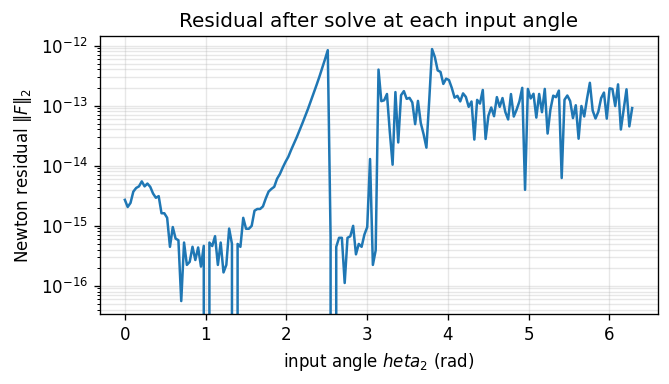

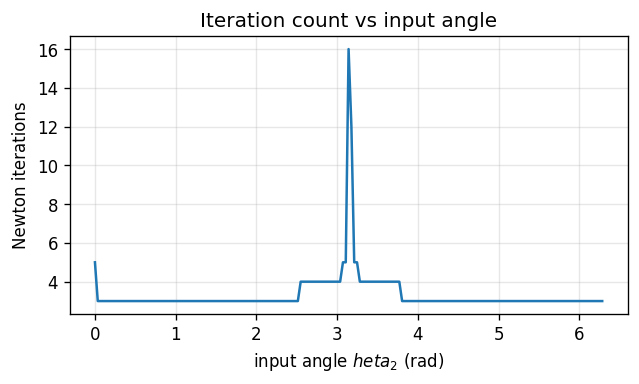

(array([], dtype=int64), 0)

In [7]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(th2_vals, residuals, lw=1.5)
ax.set_yscale('log')
ax.set_xlabel(r'input angle $	heta_2$ (rad)')
ax.set_ylabel(r'Newton residual $\|F\|_2$')
ax.set_title('Residual after solve at each input angle')
ax.grid(True, which='both', alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(th2_vals, iters, lw=1.5)
ax.set_xlabel(r'input angle $	heta_2$ (rad)')
ax.set_ylabel('Newton iterations')
ax.set_title('Iteration count vs input angle')
ax.grid(True, alpha=0.3)
plt.show()

# If any points failed, show indices
fail_idx = np.where(~converged)[0]
fail_idx[:10], len(fail_idx)


If you see failures near certain angles, that often corresponds to a **toggle** (near-singular Jacobian) or jumping between assembly modes.
For a classroom demo, it’s fine to pick link lengths and an initial guess that give a clean sweep.


## 5) Compute joint coordinates for animation

In [8]:
def joint_coords(th2v, th3v, th4v, r1v, r2v, r3v, r4v):
    """Return coordinates of O2, A, B, O4."""
    O2 = np.array([0.0, 0.0])
    O4 = np.array([r1v, 0.0])

    A = O2 + r2v*np.array([np.cos(th2v), np.sin(th2v)])
    # B from output rocker
    B = O4 + r4v*np.array([np.cos(th4v), np.sin(th4v)])

    # (Optional) coupler end check: distance AB should be r3
    return O2, A, B, O4

# Quick check at a few frames
for idx in [0, n_steps//4, n_steps//2]:
    O2, A, B, O4 = joint_coords(th2_vals[idx], th3_vals[idx], th4_vals[idx], r1v, r2v, r3v, r4v)
    print(idx, " |AB| =", np.linalg.norm(B-A), " target r3 =", r3v)


0  |AB| = 3.9999999999999982  target r3 = 4.0
45  |AB| = 4.0  target r3 = 4.0
90  |AB| = 4.000000000000397  target r3 = 4.0


Note: In this formulation we solve for \(\theta_3\) and \(\theta_4\) that satisfy the loop closure.
The point \(B\) is placed using \(\theta_4\), and the coupler angle \(\theta_3\) is part of the closure equations.


## 6) Animate the mechanism motion

In [9]:
# Figure limits (pad so it looks nice)
pad = 1.0
xmin = -pad
xmax = r1v + max(r2v, r4v) + pad
ymin = -max(r2v, r3v, r4v) - pad
ymax =  max(r2v, r3v, r4v) + pad

fig, ax = plt.subplots(figsize=(6,4))
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(True, alpha=0.3)
ax.set_title('Four-bar linkage motion (Newton solve at each $\,\theta_2$)')

# Lines for links
line_ground, = ax.plot([], [], lw=3)   # O2-O4
line_input,  = ax.plot([], [], lw=3)   # O2-A
line_coupler,= ax.plot([], [], lw=3)   # A-B
line_output, = ax.plot([], [], lw=3)   # O4-B

# Joint markers
pts, = ax.plot([], [], 'o', ms=6)

# Text annotation
txt = ax.text(0.02, 0.98, '', transform=ax.transAxes, va='top')

def init():
    line_ground.set_data([], [])
    line_input.set_data([], [])
    line_coupler.set_data([], [])
    line_output.set_data([], [])
    pts.set_data([], [])
    txt.set_text('')
    return line_ground, line_input, line_coupler, line_output, pts, txt

def update(frame):
    th2v = th2_vals[frame]
    th3v = th3_vals[frame]
    th4v = th4_vals[frame]

    O2, A, B, O4 = joint_coords(th2v, th3v, th4v, r1v, r2v, r3v, r4v)

    # Ground
    line_ground.set_data([O2[0], O4[0]], [O2[1], O4[1]])
    # Input
    line_input.set_data([O2[0], A[0]], [O2[1], A[1]])
    # Coupler
    line_coupler.set_data([A[0], B[0]], [A[1], B[1]])
    # Output
    line_output.set_data([O4[0], B[0]], [O4[1], B[1]])

    # Joints
    X = [O2[0], A[0], B[0], O4[0]]
    Y = [O2[1], A[1], B[1], O4[1]]
    pts.set_data(X, Y)

    txt.set_text(
        rf'$\theta_2={th2v:.2f}$ rad' + '\n' +
        rf'$\theta_3={wrap_pi(th3v):.2f}$ rad, $\theta_4={wrap_pi(th4v):.2f}$ rad' + '\n' +
        rf'$\|F\|_2={residuals[frame]:.1e}$, iters={iters[frame]}'
    )
    return line_ground, line_input, line_coupler, line_output, pts, txt

anim = FuncAnimation(fig, update, frames=n_steps, init_func=init,
                     interval=30, blit=True)

plt.close(fig)  # prevents duplicate static display in some environments
anim


<>:13: SyntaxWarning: invalid escape sequence '\,'
<>:13: SyntaxWarning: invalid escape sequence '\,'
/var/folders/2m/lvv_r6ks2d7djtj7drc_v2th0000gn/T/ipykernel_20658/4212902070.py:13: SyntaxWarning: invalid escape sequence '\,'
  ax.set_title('Four-bar linkage motion (Newton solve at each $\,\theta_2$)')


### Saving the animation (optional)

If you have FFmpeg installed:
```python
anim.save('fourbar.mp4', fps=30)
```

Or as a GIF (can be larger):
```python
anim.save('fourbar.gif', fps=20)
```
